In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import os
from astropy import units as u
from astropy.coordinates import SkyCoord as scr
import seaborn as sns
import scipy as sp
import load

# OBJECTIVES

Split the data energy wise 
## (0.3-1 TeV, 1-3 TeV, 3-10 TeV)

 Redo both sets of experiments (Task 1 and Task 2)

For method 2 (when counting no of matches within the neutrino error circle) instead of
counting the background events by looking at the no of neutrino-MSP pairs within the same cos(error region) offset by 5 degrees,

    Follow the same method as in        https://arxiv.org/pdf/2112.11375v1.pdf      which is briefly summarized below

        1. Generate a synthetic catalog of MSPs uniformly distributed in the same RA and DEC range as observed population

        2, Count no of coincidences  within neutrino error circle for the synthetic catalog in (1). 

        3. Repeat step (1) and (2) 100 times and take the average.

## IMPORTING DATA



### SPLITTING THE DATA

In [2]:
path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
 "IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')

lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]

In [3]:
icdata = icdata.sort_values('log10(E/GeV)')
icdata = icdata.reset_index()
icdata = icdata.drop('index', axis=1)

In [4]:
icdata

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,57406.38557611,1.05,14.40,36.393,40.665,310.371,130.743
1,57741.89209354,1.07,9.90,46.209,31.837,93.586,121.900
2,56247.41003029,1.11,7.35,204.188,48.589,89.178,138.519
3,57776.35241772,1.11,10.81,273.928,32.625,65.663,122.631
4,57821.93460663,1.16,12.40,159.925,35.709,74.086,125.616
...,...,...,...,...,...,...,...
1134445,57850.41489986,7.00,1.48,299.091,-19.242,135.893,70.801
1134446,56616.28975047,7.01,1.24,300.952,-48.575,312.569,41.469
1134447,57741.31320782,7.04,3.27,226.680,-7.559,64.185,82.379
1134448,58099.46879008,7.26,3.32,317.013,-34.929,22.825,55.146


In [5]:
icpartitions = (np.log10(300), np.log10(1000), np.log10(3000), np.log10(10000))
lwall = [0]
rwall = []
for i in range(0,len(icpartitions)):
    lwall.append(min(icdata[icdata['log10(E/GeV)'] > icpartitions[i]].index))
    rwall.append(max(icdata[icdata['log10(E/GeV)'] <= icpartitions[i]].index))
lwall.pop(-1)

761789

In [6]:
lwall

[0, 7056, 338985, 676197]

In [7]:
rwall

[7055, 338984, 676196, 761788]

In [8]:
ic = [icdata[lwall[i]:rwall[i] + 1] for i in range(len(lwall))]

In [9]:
ic.pop(0)
len(ic)

3

In [10]:
for i in range(3):
    ic[i] = ic[i].reset_index()
    ic[i] = ic[i].rename(columns={'index': 'oindex'})

In [11]:
extensions = [441 - len(ic[i])%441 for i in range(3)]

In [12]:
sum(extensions)

700

In [13]:
icra = [[float(i) for i in ic[j]['RA[deg]']] for j in range(3)]
icdec = [[float(i) for i in ic[j]['Dec[deg]']] for j in range(3)]
icang = [[float(i) for i in ic[j]['AngErr[deg]']] for j in range(3)]

In [14]:
for i in range(3):
    icra[i].extend([0]*extensions[i])
    icdec[i].extend([0]*extensions[i])
    icang[i].extend([0]*extensions[i])

In [15]:
#IMPORTING AND CLEANING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/10milsecpsr.txt", 'r')
lines = f.readlines()

content=[]
column=lines[3].split()

for line in lines[:]:
    content.append(line.split())

#the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
mspdata = pd.DataFrame(content).drop(range(0,6)).dropna().drop([2,6,8,10,11,13,14], axis=1)
f.close()
line = []
lines = []

mspdata.columns = column
column = []
content=[]
mspdata.dropna(inplace=True)
mspdata = mspdata.reset_index()
mspdata = mspdata.drop(["index", "#"], axis=1)


msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
cos5 = np.cos(np.deg2rad(5))

In [16]:
msra2, msdec2 = load.gen_cat(min(msra), max(msra), min(msdec), max(msdec))

In [17]:
sp_ang, cosp_ang = load.t2a2b(icra, icdec, msra2, msdec2, extensions)

#### Task 2A - Output

#### SPACE ANGLE DISTRIBUTION

In [1]:
fig, ax = plt.subplots(1, 3,  figsize=(84,30))
plt.rcParams.update({'font.size': 40})
titles = ['0.3TeV - 1 TeV', '1 TeV - 3 TeV', '3 TeV - 10 TeV']
plt.setp(ax,xlabel="theta (deg)")
plt.setp(ax,ylabel="N")
plt.suptitle('DISTRIBUTION OF SPACE ANGLE BETWEEN EACH NEUTRINO EVENT DETECTED BY ICECUBE(2008-18) AND\n EACH MILLISECOND PULSAR IN THE ATNF CATALOGUE(1.67)\n\nSYNTHETIC\n')
#fig.text(0.5, 0.5, 'ORIGINAL\n', horizontalalignment='center', verticalalignment='center', fontsize=64)
nbins = np.arange(0, 35, 5)

#fig.text(0.5, 0.5, '\n\nSYNTHETIC\n', horizontalalignment='center', verticalalignment='center', fontsize=64)
for x in range(3):
    ax[x].ticklabel_format(useOffset=False, style='plain', axis='y', size=40)
    ax[x].hist(sp_ang[x], bins= nbins)
    ax[x].set_title(titles[x] + '\n')
    #ax.grid(True, which="both")
plt.show()

NameError: name 'plt' is not defined

#### TASK 2B OUTPUT
#### COSINE OF SPACE ANGLE DISTRIBUTION

In [19]:
freq, nbins, bground, signal = load.t2bs(cosp_ang)

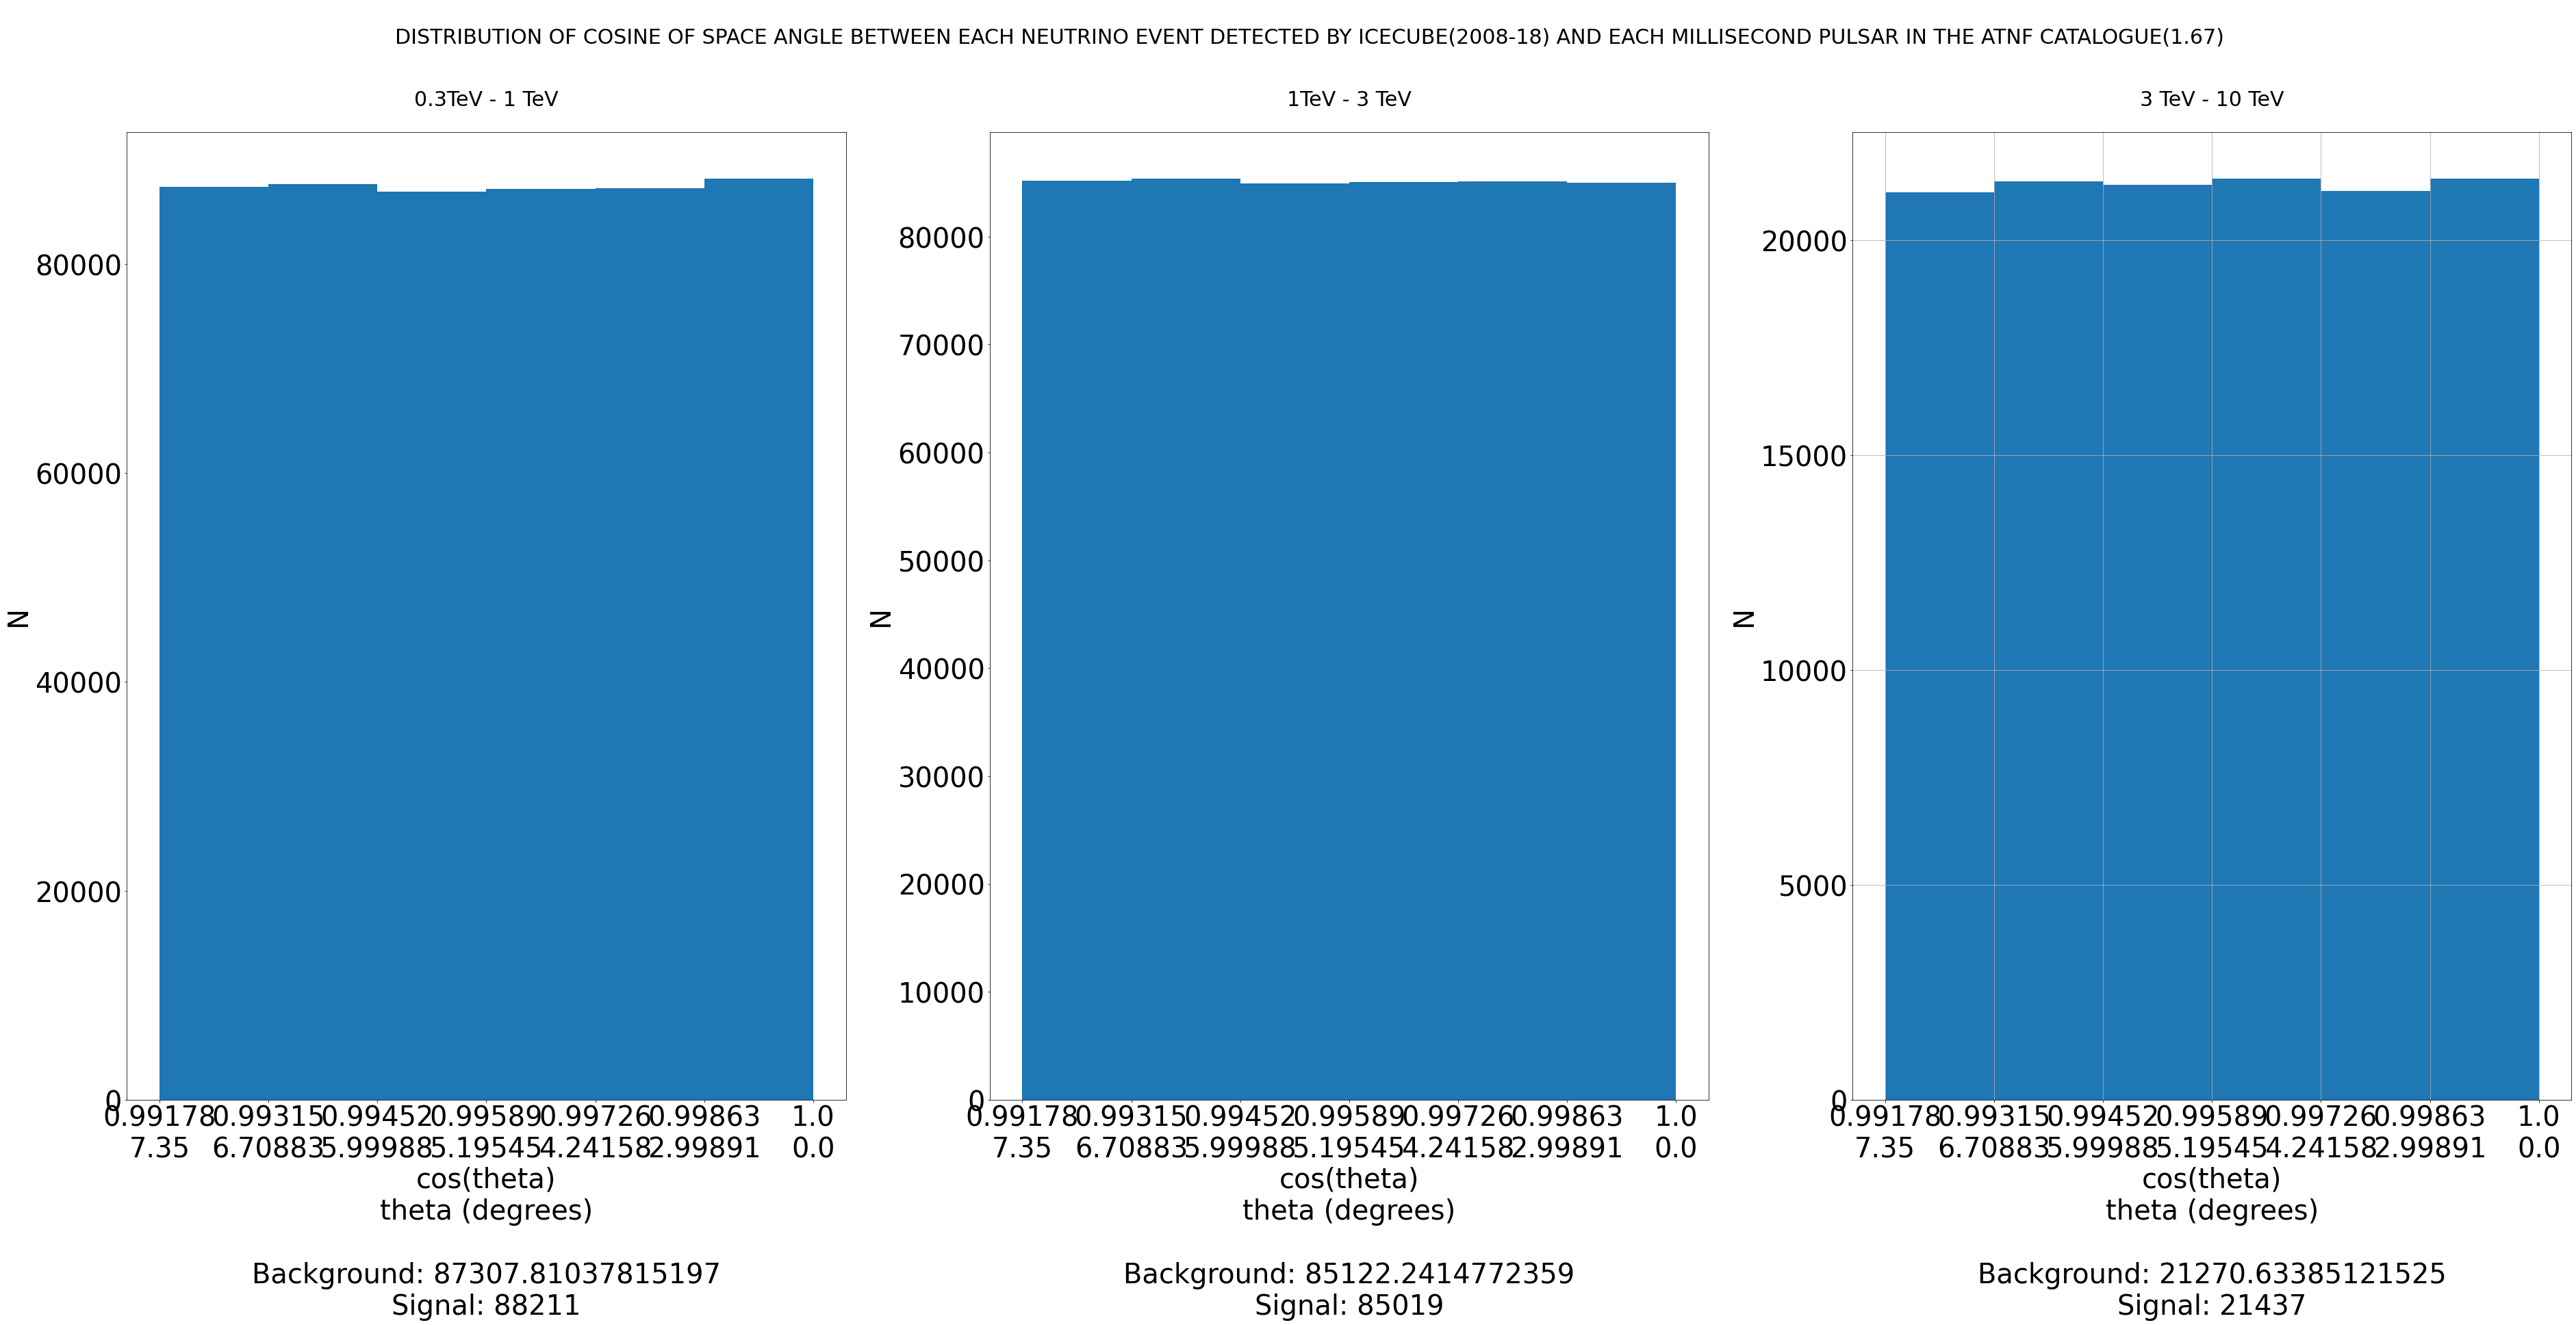

In [20]:
fig, ax = plt.subplots(1, 3,  figsize=(64,26))
plt.rcParams.update({'font.size': 25})
plt.suptitle('\nDISTRIBUTION OF COSINE OF SPACE ANGLE BETWEEN EACH NEUTRINO EVENT DETECTED '
                                +'BY ICECUBE(2008-18) AND EACH MILLISECOND PULSAR IN THE ATNF CATALOGUE(1.67)\n\n')
nb = ['0.99178\n7.35', '0.99315\n6.70883', '0.99452\n5.99988', '0.99589\n5.19545', '0.99726\n4.24158', '0.99863\n2.99891', '1.0\n0.0']
#plt.hist(r, bins= nbins, edgecolor="black")

plt.setp(ax,ylabel="N")
for x in range(3):
    plt.setp(ax[x], xlabel = f"cos(theta)\ntheta (degrees)\n\nBackground: {bground[x]}\nSignal: {signal[x]}")
    plt.xticks(nbins, nb)
    ax[x].set_title(titles[x] + '\n')
    ax[x].set_xticks(nbins, nb)
    ax[x].stairs(freq[x], nbins, fill=True)
    #ax[x].xticks(nbins, nb)

plt.grid(True, which="both")
#plt.show()

In [21]:
licra = [len(icra[i]) for i in range(3)]
lmsra = len(msra2)

## TASK 2C
### OUTPUT

In [22]:
match = load.t2c(icra,icdec, icang, msra2, msdec2, extensions)

In [23]:
match

[9510, 7319, 3328]

In [30]:
for i in range(3):
    print(f"{titles[i]}: {match[i]}")

0.3TeV - 1 TeV: 9510
1TeV - 3 TeV: 7319
3 TeV - 10 TeV: 3328


## TASK 2D
### OUTPUT

In [24]:
background = load.t2d(icra, icdec, icang, msra2, msdec2, extensions)

In [31]:
background

[27286, 20143, 3545]

In [32]:
for i in range(3):
    print(f"{titles[i]}: {background[i]}")

0.3TeV - 1 TeV: 27286
1TeV - 3 TeV: 20143
3 TeV - 10 TeV: 3545
